# 1. Introduction:

This notebook demonstrates -

1. Use of DPU and Preprocessing Accelerators to perform AI Inference on video input.
2. Option to run different AI models like facedetect, refinedet, and SSD using the same set of accelerators.

The application is based on the VVAS (Vitis Video Analytics SDK) framework, also utilizing the open source GStreamer plugins.

Vitis Video Analytics SDK (VVAS) is developed by Xilinx to provide many useful GStreamer plugins as the middleware between the application and underlying FPGA accelerators, including DPU AI inference engine, and other PL accelerators such as the one for AI input preprocessing.

Please refer to the [Kria™ KV260 Vision AI Starter Kit Applications GitHub Pages](https://xilinx.github.io/kria-apps-docs/index.html) for detailed HW/SW architecture and [Vitis Video Analytics SDK GitHub Pages](https://xilinx.github.io/VVAS/#) for the VVAS related info.

# 2. Import modules

In [1]:
import IPython
from IPython.display import *
import ipywidgets as widgets
from ipywidgets import *
import time       

# 3. Video Pipeline

Pipeline flow-

The VCU decode the H264 file to NV12 format.
The preprocessing block resizes, quantizes, and converts to BGR format.
DPU does the AI inference based on the model selected and generates bounding box data.
Meta Affixer scales the bounding box data received wrt the resolution of vcu decoded output.
The bounding box draws the results around the objects of interest.

PL - Pre-proc, DPU

Hardened Block - VCU Dec, Display Port

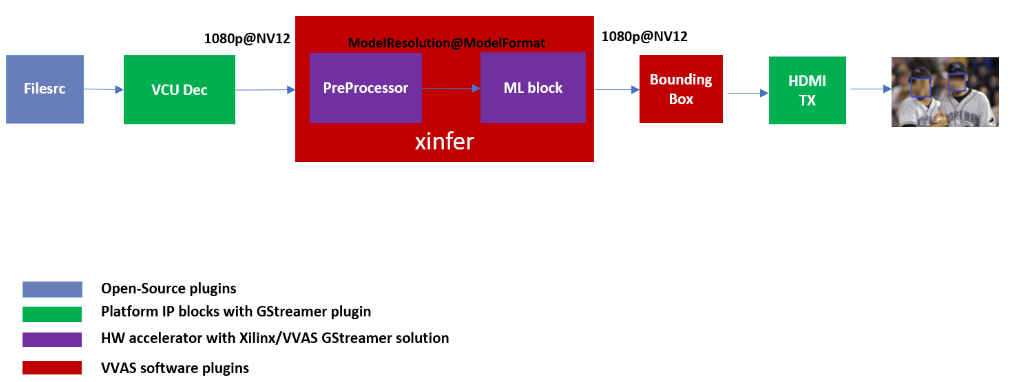

In [2]:
from IPython.display import Image
Image(filename='./images/ml-inference.png')

* Slot_config=0 for DPU-slot0 and PP_PIPELINE-slot1. 

  Slot_config=1 for DPU-slot1 and PP_PIPELINE-slot0. 
  
  Default Configuraton is DPU in slot0 and PP_PIPELINE in slot1. 

In [3]:
slotconfig=["dpu_slot0","dpu_slot1"]

In [4]:
w = widgets.Dropdown(options=slotconfig,value=slotconfig[0],description='slot_config :',)
slot_config= slotconfig[0]
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global slot_config
        slot_config = change['new']
w.observe(on_change)
display(w)

Dropdown(description='slot_config :', options=('dpu_slot0', 'dpu_slot1'), value='dpu_slot0')

* If DPU is in slot0 and PP_PIPELINE is in slot1, copy the dpu_slot0 xclbin.

  Elseif DPU is in slot1 and PP_PIPELINE is in slot0, copy the dpu_slot1 xclbin.

In [5]:
if(slot_config=="dpu_slot0"):
    ! cp /lib/firmware/xilinx/k26-dfx-2rp/DPU/DPU_slot0/dpu_RP_0.xclbin /lib/firmware/xilinx/k26-dfx-2rp/DPU
    ! mv /lib/firmware/xilinx/k26-dfx-2rp/DPU/dpu_RP_0.xclbin /lib/firmware/xilinx/k26-dfx-2rp/DPU/dfx-ml-inference.xclbin
    ! cp /lib/firmware/xilinx/k26-dfx-2rp/DPU/DPU_slot0/dpu_RP_0.xclbin /usr/lib
    ! mv /usr/lib/dpu_RP_0.xclbin /usr/lib/dpu.xclbin
else:
    ! cp /lib/firmware/xilinx/k26-dfx-2rp/DPU/DPU_slot1/dpu_RP_1.xclbin /lib/firmware/xilinx/k26-dfx-2rp/DPU
    ! mv /lib/firmware/xilinx/k26-dfx-2rp/DPU/dpu_RP_1.xclbin /lib/firmware/xilinx/k26-dfx-2rp/DPU/dfx-ml-inference.xclbin
    ! cp /lib/firmware/xilinx/k26-dfx-2rp/DPU/DPU_slot1/dpu_RP_1.xclbin /usr/lib
    ! mv /usr/lib/dpu_RP_1.xclbin /usr/lib/dpu.xclbin 

# 4. Choose AI Inference Model

* Option to set required AI model 

facedetect - Used for face detection 

refinedet - Used for object detection 

ssd - Single shot detection used for Object detection

In [6]:
aitask= [ "refinedet","facedetect","ssd" ]

In [7]:
w = widgets.Dropdown(options=aitask,value=aitask[0],description='ai_task :',)
ai_task = aitask[0]
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global ai_task 
        ai_task = change['new']
w.observe(on_change)
display(w)

Dropdown(description='ai_task :', options=('refinedet', 'facedetect', 'ssd'), value='refinedet')

* Running Input media Sample Video.

SSD model uses Road-Adas media file. 

Facedetect and refinedet uses walking people media file.

In [8]:
if ai_task == 'ssd':
    src = './Road-Adas.nv12.h264'
else:
    src = './walking-people.nv12.h264'

Set display mode to 1920x1080 for the KV260 board and 1024x768 for the KR260 board if its not detected. 

Display mode can be set using- 

modetest -D fd4a0000.display -s 43@41:1920x1080-60@BG24 

modetest -D fd4a0000.display -s 43@41:1024x768-60@BG24 


In [11]:
! gst-launch-1.0 filesrc location={src} ! h264parse ! omxh264dec !  tee name=t0 t0.src_0 !  queue !  kmssink bus-id=fd4a0000.display  sync=false fullscreen-overlay=true > /dev/null 2>&1

# 5. Run AI Inference

In [9]:
confdir="/opt/xilinx/dfx-ml-inference/vvas/config/"+ ai_task

Bounding box will come on the region of interest on the monitor depending upon the chosen model. 

Pipeline running on Input file-

Set display mode to 1920x1080 for the KV260 board and 1024x768 for the KR260 board if its not detected. 

Display mode can be set using- 

modetest -D fd4a0000.display -s 43@41:1920x1080-60@BG24 

modetest -D fd4a0000.display -s 43@41:1024x768-60@BG24 

gst-launch-1.0 filesrc location={src} ! h264parse ! omxh264dec ! tee name=t0 ! queue ! vvas_xmultisrc kconfig="{confdir}/preprocess.json" ! vvas_xfilter kernels-config="{confdir}/aiinference.json" ! scalem0.sink_master vvas_xmetaaffixer name=scalem0 scalem0.src_master ! fakesink t0. ! queue max-size-buffers=1 leaky=2 ! scalem0.sink_slave_0 scalem0.src_slave_0 ! queue ! vvas_xfilter kernels-config="{confdir}/drawresult.json" ! queue ! kmssink  bus-id=fd4a0000.display sync=false fullscreen-overlay=true

In [10]:
! gst-launch-1.0 filesrc location={src} ! h264parse ! omxh264dec ! tee name=t0 ! queue ! vvas_xmultisrc kconfig="{confdir}/preprocess.json" ! vvas_xfilter kernels-config="{confdir}/aiinference.json" ! scalem0.sink_master vvas_xmetaaffixer name=scalem0 scalem0.src_master ! fakesink t0. ! queue max-size-buffers=1 leaky=2 ! scalem0.sink_slave_0 scalem0.src_slave_0 ! queue ! vvas_xfilter kernels-config="{confdir}/drawresult.json" ! queue ! kmssink bus-id=fd4a0000.display sync=false fullscreen-overlay=true > /dev/null 2>&1

# 6. Summary
The Jupyter application shows how to use two accelerators-DPU and PP_PIPELINE in different slots to do the inference on the incoming frames, and draw bound boxing of detected results.
Both accelerators work in both slots.

<center>Copyright© 2023 Xilinx</center>